In [8]:
import pandas as pd
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='dark')
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv('ex1data1.txt', names = ['population','profit'])

In [100]:
df.head(7)

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233
5,8.3829,11.8860
6,7.4764,4.3483


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
population    97 non-null float64
profit        97 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB


C:\Users\Administrator\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


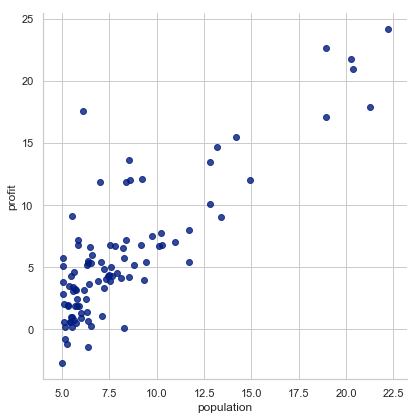

In [9]:
sns.lmplot('population', 'profit', df, size=6, fit_reg=False)
plt.show()

### 数据处理

In [96]:
# 读取特征
def get_X(df):
    ones = pd.DataFrame({'ones': np.ones(len(df))})
    # 根据列合并数据
    data = pd.concat([ones, df], axis=1)
    # 返回ndarray，不是矩阵
    return data.iloc[:,:-1].values

In [71]:
# 读取标签
def get_Y(df):
    return np.array(df.iloc[:,-1])

> 特征缩放
$$ x_{n}=\dfrac {x_{n}-u_{n}}{s_{n}} $$

In [90]:
# 特征缩放
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean()) / column.std())

> 多变量的假设 h 表示为：\\[{{h}_{\theta }}\left( x \right)={{\theta }_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 
这个公式中有n+1个参数和n个变量，为了使得公式能够简化一些，引入${{x}_{0}}=1$， 
此时模型中的参数是一个n+1维的向量，任何一个训练实例也都是n+1维的向量，特征矩阵X的维度是 m*(n+1)。 因此公式可以简化为：${{h}_{\theta }}\left( x \right)={{\theta }^{T}}X$，其中上标T代表矩阵转置。


> 代价函数
$$J\left( \theta  \right)=\frac{1}{2m}\sum\limits_{i=1}^{m}{{{\left( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \right)}^{2}}}$$
其中：\\[{{h}_{\theta }}\left( x \right)={{\theta }^{T}}X={{\theta }_{0}}{{x}_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 

In [92]:
def linear_regression(X_data, Y_data, alpha, epoch, optimizer=tf.train.GradientDescentOptimizer):
    # placeholder for graph input
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    Y = tf.placeholder(tf.float32, shape=Y_data.shape)
    
    # construct graph
    with tf.variable_scope('linear-regression'):
        W = tf.get_variable("weights", (X_data.shape[1], 1), initializer=tf.constant_initializer())
        y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1
        loss = 1 / (2 * len(X_data)) * tf.matmul((y_pred - Y), (y_pred - Y), trasponse_a = True)
    
    opt = optimizer(learning_rate = alpha)
    opt_operation = opt.minimizemize(loss)
    
    # run the session
    with tf.session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []
        
        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict={X: X_data, Y: Y_data})
            loss_data.append(loss_val[0, 0])
            
            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10 ** -9:
                print(f"Converged at epoch {i}")
                break
                
    # clear the graph
    tf.reset_default_graph()
    return {'loss': loss_data, 'parameters': W_val}

In [99]:
X = get_X(df)
print(X.shape, type(X))
Y = get_Y(df)
print(Y.shape, type(Y))

(97, 2) <class 'numpy.ndarray'>
(97,) <class 'numpy.ndarray'>


In [101]:
# 特征数
theta = np.zeros(X.shape[1])
theta

array([0., 0.])

In [102]:
# linear regression cost
def lr_cost(theta, X, Y):
    m = X.shape[0]  # 样本数
    y_pred = X @ theta
    inner = y_pred - Y  
    square_sum = inner.T @ inner  # 相当于 np.sum(np.square(a, b))
    cost = square_sum / (2 * m)
    return cost

In [103]:
lr_cost(theta, X, Y)

32.072733877455676

## 批量梯度下降 -- batch gradient decent
$${{\theta }_{j}}:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right)$$

In [104]:
def gradient(theta, X, Y):
    m = X.shape[0]
    inner = X.T @ (X @ theta - Y)
    return inner / m

In [105]:
def batch_gradient_decent(theta, X, Y, epoch, alpha = 0.01):
    cost_data = [lr_cost(theta, X, Y)]
    theta_ = theta.copy()
    
    for _ in range(epoch):
        theta_ = theta_ - alpha * gradient(theta_, X, Y)
        cost_data.append(lr_cost(theta_, X, Y))
        
    return theta_, cost_data

In [106]:
epoch = 500
final_theta, cost_data = batch_gradient_decent(theta, X, Y, epoch)

In [ ]:
final_theta, cost_data

In [108]:
lr_cost(final_theta, X, Y)

4.713809531116866

## 数据可视化

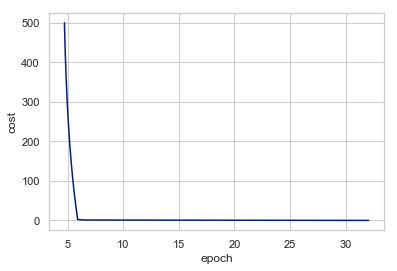

In [118]:
ax = sns.lineplot(x=cost_data, y=np.arange(epoch+1))
ax.set_xlabel('epoch')
ax.set_ylabel('cost')
plt.show()